In [65]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap, BoundaryNorm
from heapq import heapify, heappush, heappop

In [66]:
class ship:
    def __init__(self, data, open = set(), leak = [()], bot = (), closed = set()):
        self.data = data # this should be numpy matrix
        self.open = open # set of tuples, each tuple has indices of open cell
        self.leak = leak #tuple
        self.bot = bot # tuple
        self.closed = closed # list of tuples

    
    @classmethod
    def CreateShip(cls,n):
        ship = cls(np.ones((n,n), dtype = float))
        #Pick random cell in interior to open
        x_rand, y_rand = random.randint(1, ship.data.shape[0]-2) , random.randint(1, ship.data.shape[1]-2)
        ship.data[x_rand][y_rand] = 0
        ship.open = {(x_rand, y_rand)} # We use {} to make a set, now we don't have to worry about any duplicates
        return ship  
    
    def ShowShip(self): 
        # white = open cells, black = closed cells, red = fire, blue = bot, green = leak
        colors = ['white', 'black', 'red', 'blue', 'green']
        custom_map = ListedColormap(colors)
        bounds = [-.1, .5, 1.5, 2.5, 3.5, 4.5]
        norm = BoundaryNorm(bounds, custom_map.N)
        plt.imshow(self.data, cmap = custom_map, norm=norm)
        
        #Ensure shows plot with increments of 1
        plt.xticks(np.arange(-0.5, self.data.shape[1], 1), labels=[])
        plt.yticks(np.arange(-0.5, self.data.shape[0], 1), labels=[])

        #Show gridlines 
        plt.grid(True)

        #Show colorbar
        plt.colorbar()
        plt.show()

    #Helper method that takes in indices and returns list of tuples that is 4 cardinal neighbors
    @staticmethod
    def getNeighbors(ind):
        up = (ind[0]-1, ind[1])
        down = (ind[0]+1, ind[1])
        left = (ind[0], ind[1]-1)
        right = (ind[0], ind[1]+1)
        return [up, down, left, right]
    
     # Helper to see if indices are within upper and lower bounds
    @staticmethod
    def checkBounds(upper, lower, ind):
        for i in ind:
            if i > upper or i < lower:
                return False
        return True
    
    #Helper method that takes a list of directions and ensures they're w/in bounds
    def getInbounds(self, dir):
        k = 0
        while k in range(len(dir)):
            if not ship.checkBounds(self.data.shape[0]-1, 0, dir[k]):
                del dir[k]
            else:
                k+=1
        return dir
    
    # Helper method, takes in an open cell and returns list of closed neighbors
    def checkNeighborsOpen(self, openInd):
        neighbors = ship.getNeighbors(openInd)
        valid,k = self.getInbounds(neighbors),0
        while k in range(len(valid)):
            r, c = valid[k] #unpack tuple
            if self.data[r][c] != 1:
                del valid[k]
            else:
                k+=1
        return valid
        
    #Takes in index which is a tuple that represents a cell. Checks to see if it has exactly one open neighbor
    def checkNeighborsClosed(self, Ind):
        neighbors = ship.getNeighbors(Ind)
        valid = self.getInbounds(neighbors)
        numOpen = 0
        for direction in valid:
            i,j = direction
            if self.data[i][j] == 0:
                numOpen+=1
        if numOpen == 1:return True
        return False
    
    def getDeadEnds(self):
        dead_ends = []
        for openInd in self.open:
            if self.checkNeighborsClosed(openInd):
                dead_ends.append(openInd)
        return dead_ends

    def openDeadEnds(self):
        dead_ends = self.getDeadEnds()
        for i in range(len(dead_ends)//2): # Want to open ~half the dead ends
            valid_neighbors = self.getInbounds(ship.getNeighbors(dead_ends[i]))
            closed_neighbors = []
            for neighbor in valid_neighbors:
                i,j = neighbor
                if self.data[i][j] == 1:
                    closed_neighbors.append(neighbor)

            #Now we have closed neighbors of dead end, choose one at random and open
            ri = None
            if len(closed_neighbors)-1 > 0:
                ri = random.randint(0, len(closed_neighbors)-1)
                rx, ry = closed_neighbors[ri]
                self.data[rx][ry] = 0

    # In order to more efficiently open the ship we only check the blocked cells that are next to open cells
    # Then we can see which of those blocked cells has exactly 1 open neighbor.
    # While this set is not empty, we choose a random cell in the set to open
    def OpenShip(self):
        while True:         
            possibly_valid_blocked, valid_blocked = [],[]
            for open in self.open:
                possibly_valid_blocked += self.checkNeighborsOpen(open)
            for possibly_valid in possibly_valid_blocked:
                if self.checkNeighborsClosed(possibly_valid): valid_blocked.append(possibly_valid)
            if len(valid_blocked) != 0:
                #choose random valid blocked and open it
                ri = random.randint(0, len(valid_blocked)-1)
                i, j = valid_blocked[ri]
                self.data[i][j] = 0 # Open randomly chosen cell
                self.open.add((i,j)) # Add this to set of open cells
            else:
                break
        self.openDeadEnds()

    def populateClosedCells(self):
        for i in range(len(self.data)):
            for j in range(len(self.data[0])):
                if self.data[i][j]==1:
                    self.closed.add((i,j))
    

    # Get random spawn points for bot, leak and fire
    def chooseInitSpawns(self):
        openlist = list(self.open)
        obj = random.sample(openlist, 1)
        for i in range(len(obj)):
            self.open.discard(obj[i])
            x,y = obj[i]
            self.data[x][y] = i+2
        # self.leak = obj[1]
        self.bot = obj[0]

    def create_detection_square(self, matrix, pivot, k):
        """Creates a detection square of size 2k+1 x 2k+1 around the pivot point.

        Args:
            matrix: A 2D numpy array.
            pivot: A tuple of (row, col) coordinates.
            k: An integer greater than 0 and less than 8.

        Returns:
            A 2D numpy array containing the detection square.
        """
        # Check if the pivot point is within the bounds of the matrix.
        if pivot[0] < 0 or pivot[0] >= matrix.shape[0] or pivot[1] < 0 or pivot[1] >= matrix.shape[1]:
            raise ValueError("Pivot point is out of bounds.")

        # Calculate the start and end indices of the detection square.
        start_row = pivot[0] - k
        end_row = pivot[0] + k + 1
        start_col = pivot[1] - k
        end_col = pivot[1] + k + 1

        # Check if the detection square goes out of bounds of the matrix.
        if start_row < 0:
            start_row = 0
        if end_row >= matrix.shape[0]:
            end_row = matrix.shape[0]
        if start_col < 0:
            start_col = 0
        if end_col >= matrix.shape[1]:
            end_col = matrix.shape[1]

        # Create the detection square.
        detection_square = []
        for i in range(start_row, end_row):
            for j in range(start_col, end_col):
                detection_square.append((i,j))
        # print(matrix[start_row:end_row, start_col:end_col])

        all_coordinates = []
        for row in range(matrix.shape[0]):
            for col in range(matrix.shape[1]):
                all_coordinates.append((row, col))

        outside_coordinates = []
        for coordinate in all_coordinates:
            if coordinate not in detection_square:
                outside_coordinates.append(coordinate)

        for coors in detection_square:
            x,y = coors
            if self.data[x][y] == 1 or self.data[x][y] == 3:
                detection_square.remove(coors)

        for coors in detection_square:
            if coors in self.closed or coors in self.bot:
                detection_square.remove(coors)
        
        for coors in outside_coordinates:
            x,y = coors
            if self.data[x][y] == 1:
                outside_coordinates.remove(coors)

        for coors in outside_coordinates:
            if coors in self.closed or coors in self.bot:
                outside_coordinates.remove(coors)

        return (detection_square, outside_coordinates)  
    
    def manhattan(self, bot, pos):
        botx, boty = bot[0], bot[1]
        posx, posy = pos[0], pos[1]
        sqx = (botx-posx)**2
        sqy = (boty - posy)**2
        sqrt = (sqx + sqy)**(1/2)
        return int(sqrt)

    def moveBotToPos(self, start, dest, vis):

        def findPath(start, dest):
            q = []
            parent = {}
            q.append(start)
            vis.add(start)
            parent[start] = None
            while len(q) > 0:
                curr = q.pop(0)
                if curr == dest:
                    path = []
                    while curr is not None:
                        path.append(curr)
                        curr = parent[curr]
                        if curr == self.leak:
                            actions = len(path)
                            path[0] = 's'
                            return actions, path[0]
                    path.reverse()
                    return path
                neighbors = self.findBFSNeighbors(curr)
                for neighbor in neighbors:
                    if neighbor not in vis:
                        q.append(neighbor)
                        vis.add(neighbor)
                        parent[neighbor] = curr
            return []
        
        path = findPath(start, dest)
        actions = len(path)
        return actions, path

    def moveBot(self, oldPos, newPos):
        self.open.add(oldPos)
        self.bot = newPos
        self.data[newPos[0]][newPos[1]] = 3
        self.data[oldPos[0]][oldPos[1]] = 0

    def findBFSNeighbors(self, cell):
        closed = self.closed
        up = (cell[0] - 1, cell[1])
        if up in self.closed:
            up = None 
        down = (cell[0] + 1, cell[1])
        if down in self.closed:
            down = None
        right = (cell[0], cell[1]+ 1)
        if right in self.closed:
            right = None
        left = (cell[0], cell[1]-1)
        if left in self.closed:
            left = None
        pot = [up, down, left, right]
        valid = []
        for n in pot:
            if n != None:
                if self.checkBounds(self.data.shape[0]-1, 0, n):
                    valid.append(n)
        return valid


    def bot1(self, k):
        #create generalized initalize ship method and run here
        openlist = list(self.open)
        obj = random.sample(openlist, 1)[0]
        self.open.discard(obj)
        self.data[obj[0]][obj[1]] = 3
        self.bot = obj
        detectionSquare, outSideCoors = self.create_detection_square(self.data, self.bot, k)
        leakSpots = random.sample(outSideCoors,1)[0]
        self.open.discard(leakSpots)
        self.data[leakSpots[0]][leakSpots[1]] = 4
        self.leak = leakSpots
        actions = 0
        visited = set()
        visited.add(self.bot)
        mayContainLeak = list(self.open)
        # mayContainLeak.append(self.bot)
        mayContainLeak.append(self.leak)
        c = 0
        while self.leak != self.bot:
            if c > 100:
                return "failure"
            self.ShowShip()
            detectionSquare, outSideCoors = self.create_detection_square(self.data, self.bot, k)
            oldBot = self.bot
            visited.add(oldBot)
            if self.leak not in detectionSquare:
                for cells in detectionSquare:
                    if cells in mayContainLeak:
                        mayContainLeak.remove(cells)
            else:
                mayContainLeak = detectionSquare
            min = 10000
            path = []
            path.append(0)
            for pos in mayContainLeak:
                dist = self.manhattan(self.bot, pos)
                if dist < min:
                    min = dist
                    if path[0] not in visited:
                        path[0] = pos
            act, travel =  self.moveBotToPos(self.bot, path[0], visited) #return action steps
            actions += act
            for cells in travel:
                visited.add(cells)
            self.moveBot(self.bot, path[0])
            if self.bot in mayContainLeak:
                mayContainLeak.remove(self.bot)
            if oldBot == self.bot:
                if mayContainLeak == detectionSquare:
                    return actions + (2 * k)
            c +=1
        return actions
    
    def bot5(self, k):
        openlist = list(self.open)
        obj = random.sample(openlist, 1)[0]
        self.open.discard(obj)
        self.data[obj[0]][obj[1]] = 3
        self.bot = obj
        detectionSquare, outSideCoors = self.create_detection_square(self.data, self.bot, k)
        leakSpots = random.sample(outSideCoors,2)
        self.open.discard(leakSpots[0])
        self.open.discard(leakSpots[1])
        self.data[leakSpots[0][0]][leakSpots[0][1]] = 4
        self.data[leakSpots[1][0]][leakSpots[1][1]] = 4
        self.leak = leakSpots
        mayContainLeak = list(self.open)
        mayContainLeak.append(self.leak)
        visited = set()
        visited.add(self.bot)
        actions = 0
        while len(self.leak) > 0:
            self.ShowShip()
            actions += 1
            detectionSquare, outSideCoors = self.create_detection_square(self.data, self.bot, k)
            if self.leak in detectionSquare:
                for cells in detectionSquare:
                    if cells in mayContainLeak:
                        mayContainLeak.remove(cells)
            else:
                mayContainLeak = outSideCoors
            path = []
            path.append(0)
            dist = {}
            for cells in mayContainLeak:
                trvl = self.manhattan(self.bot, cells)
                dist[trvl] = cells
            minCells = []
            heapify(minCells)
            for key in dist.keys():
                heappush(minCells, key)
            for cells in minCells:
                print(cells)
            act, travel =  self.moveBotToPos(self.bot, path[0], visited)
            actions += act
            for cells in travel:
                visited.add(cells)
            self.moveBot(self.bot, path[0])
            n = self.findBFSNeighbors(self.bot)
            for cells in n:
                if cells == self.leak:
                    x,y = cells
                    self.data[x][y] = 0
                    self.leak.remove(cells)
                    self.open.add(cells)
            for cells in self.leak:
                if cells == self.bot:
                    x,y = cells
                    self.data[x][y] = 0
                    self.leak.remove(cells)
                    self.open.add(cells)
            path = None
            if self.bot in mayContainLeak:
                mayContainLeak.remove(self.bot)
            self.leak = []
        return actions
            
           


In [67]:
            # for pos in mayContainLeak:
            #     dist[pos] = self.manhattan(self.bot, pos)
            # min_key = min(dist, key=lambda k: dist[k])
            # if min_key in visited:
            #     del dist[min_key]
            #     min_key = min(dist, key=lambda k: dist[k])  
            # path[0] = (min_key)
'''space_ship = ship.CreateShip(50)
totalActions = 0
totalRuns = 100
for i in range(totalRuns):
    space_ship.OpenShip()
    space_ship.openDeadEnds()
    space_ship.populateClosedCells()
    val = space_ship.bot1(15) 
    if val == 'failure':
        continue
    else:
        totalActions += val
        totalRuns-=1
print(totalActions/100)'''

"space_ship = ship.CreateShip(50)\ntotalActions = 0\ntotalRuns = 100\nfor i in range(totalRuns):\n    space_ship.OpenShip()\n    space_ship.openDeadEnds()\n    space_ship.populateClosedCells()\n    val = space_ship.bot1(15) \n    if val == 'failure':\n        continue\n    else:\n        totalActions += val\n        totalRuns-=1\nprint(totalActions/100)"

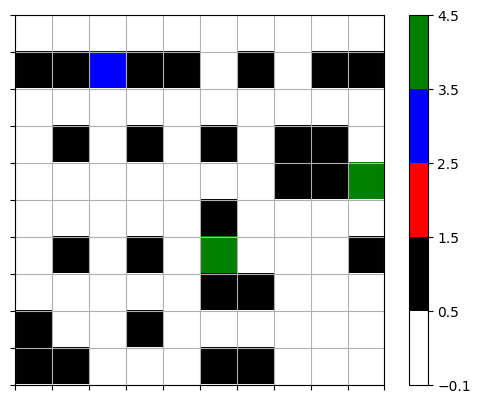

4
5
6
7
8
9
10


TypeError: 'int' object is not subscriptable

In [68]:
s = ship.CreateShip(10)
s.OpenShip()
s.openDeadEnds()
s.populateClosedCells()
s.bot5(3)